# Cryp2Moon 👩‍🚀🚀🌙

## The Team:

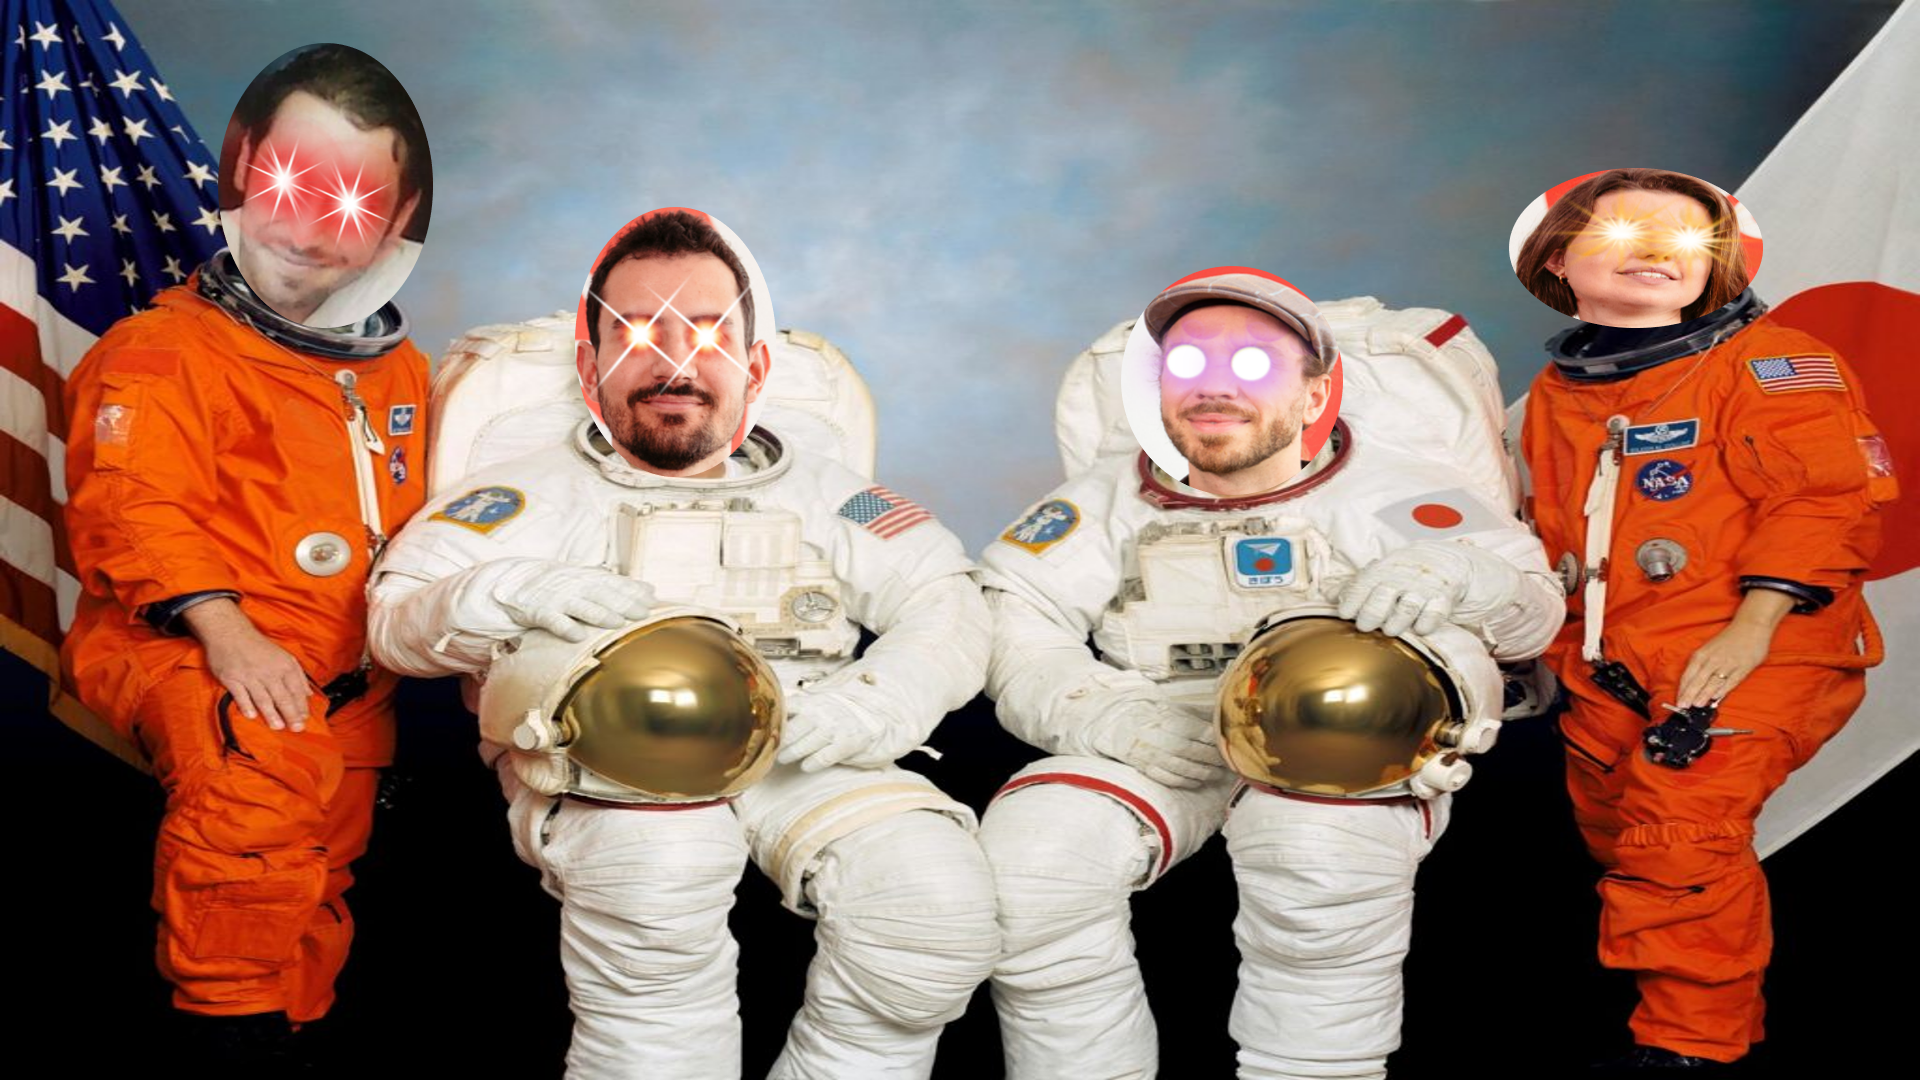

## A LSTM prediction of where Bitcoin is heading...

❓ The Problem: **Which direction is bitcoin going to swing in the shortterm?**.

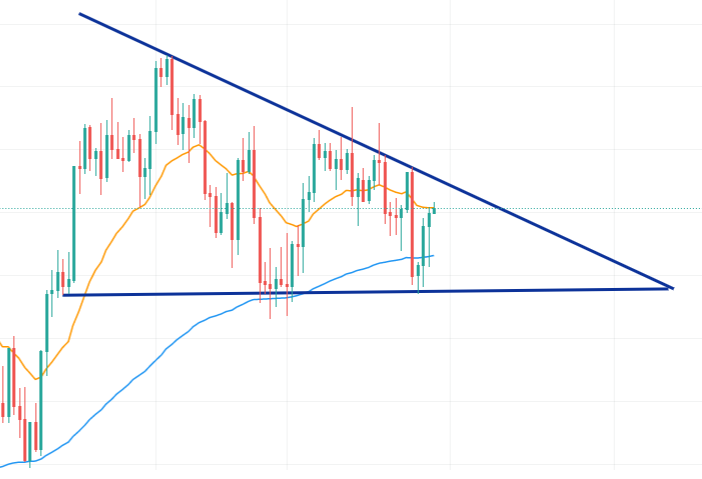

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime

In [2]:
CLOSE = 'close'
WINDOW_SIZE = 18
HORIZON = 6
SELECTED_FEATURES = ['close']

In [3]:
def feature_engineer(data):
    """
    Adds the EMAs, StochRSI, BollingerBands and Volume Rate of Change to the dataframe
    """
    add_ema(data)
    add_stoch_rsi(data)
    add_bollinger(data,data[CLOSE])
    add_vol_roc(data)
    data['4h Return'] = data[CLOSE].pct_change()
    data['4h Gradient'] = data[CLOSE].diff()
    data['boll_width'] = data['bollinger_up'] - data['bollinger_down']
    data['stoch_rsi'] = (data['K'] + data['D']) / 2
    return data

## add other features

def add_ema(data, tspan=[12,26,21,50,34,55,99,200]):
    """
    Adds Exponential Moving Averages (EMA) to the dataframe. The default timeframes are 12,26,20,50,34 and 55.
    """
    for t in tspan:
        data[f'ema{t}'] = data[CLOSE].ewm(span=t).mean()
        data[f'dist_ema{t}'] = data[CLOSE] - data[f'ema{t}']
    return data


def computeRSI(data, window=14):
    """
    Computes the Relative Stregth Index for a given dataset and the window can be defined. Its default value is 14.
    """
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=window-1 so we get decay alpha=1/window
    up_chg_avg   = up_chg.ewm(com=window-1 , min_periods=window).mean()
    down_chg_avg = down_chg.ewm(com=window-1 , min_periods=window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi


def stoch_rsi(rsi, d_window=3, k_window=3, window=14):
    """
    Computes the stochastic RSI. Default values are d=3, k=3, window=14.
    """
    minrsi = rsi.rolling(window=window, center=False).min()
    maxrsi = rsi.rolling(window=window, center=False).max()
    stoch = ((rsi - minrsi) / (maxrsi - minrsi)) * 100
    K = stoch.rolling(window=k_window, center=False).mean()
    D = K.rolling(window=d_window, center=False).mean() 
    return K, D  


def add_stoch_rsi(data, d_window=3, k_window=3, window=14):
    data['rsi'] = computeRSI(data[CLOSE], window)
    data['K'], data['D'] = stoch_rsi(data['rsi'], d_window, k_window, window)
    return data


def get_bollinger_bands(prices, rate=20):
    sma = prices.rolling(rate).mean() # <-- Get SMA for 20 days
    std = prices.rolling(rate).std() # <-- Get rolling standard deviation for 20 days
    bollinger_up = sma + std * 2 # Calculate top band
    bollinger_down = sma - std * 2 # Calculate bottom band
    return sma, bollinger_up, bollinger_down


def add_bollinger(data, prices, rate=20):
    data['sma'], data['bollinger_up'], data['bollinger_down'] = get_bollinger_bands(prices)
    for i in ['bollinger_up', 'bollinger_down']:
        data[f'dist_{i}'] = data[CLOSE] - data[i]
    return data


def add_vol_roc(data):
    data['vol_roc'] = data.volume.pct_change()
    return data

def get_train_data():
    """
    Returns the raw training dataset for the price of bitcoin since 31.12.2011.
    The index is set to the date.
    """
    data = pd.read_csv("../data/BTCUSD_4hours.csv")
    data['date'] = pd.to_datetime(data.date)
    data_train = data.drop(columns="Unnamed: 0").set_index("date")
    return data_train


def get_coingecko():
    #ohlc
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/ohlc?vs_currency=usd&days=30"
    response = requests.get(url).json()
    #cleaning
    data_api = pd.DataFrame(response, columns = ['unix_time','open', 'high', 'low', 'close'])
    data_api["Date"] = pd.to_datetime(data_api["unix_time"], unit='ms')
    data_api = data_api.drop(columns='unix_time').set_index('Date')

    #volume
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart?vs_currency=usd&days=30"
    response = requests.get(url).json()

    volume = pd.DataFrame(response['total_volumes'], columns=["unix_time","volume"])
    volume['date'] = pd.to_datetime(pd.to_datetime(volume['unix_time'],unit='ms').dt.strftime("%Y/%m/%d, %H:00:00"))
    volume = volume.drop(columns='unix_time').set_index('date')

    #resample hourly into 4h
    volume = volume.resample("4H").mean()

    #concatinate
    volume = volume[-180:]
    data_api = data_api[-181:-1]
    full = pd.concat([data_api, volume], axis=1)
    full.columns=['open', 'high', 'low', 'close', 'volume']

    for x in ['open', 'high', 'low', 'close']:
        full[f'log_{x}'] = full[x].apply(lambda x: np.log(x))

    data_api = full.copy()

    return data_api


def minmaxscaling(data_train):
    """
    applies the minmaxscaler to the training set. Attention! Output needs to be
    defined for data_train_scaled, min1 and range1!!
    """
    minmax_scaler = MinMaxScaler(feature_range=(0, 1))
    minmax_scaler.fit(data_train)
    data_train_scaled = minmax_scaler.transform(data_train)
    #    min1 = minmax_scaler.data_min_  # [5:9] for log_prices
    #    range1 = minmax_scaler.data_range_  #[5:9]
    return data_train_scaled, minmax_scaler


def get_xgecko(length=60, horizon=1):
    """
    Calls the coingecko API and returns the data used for prediction.
    x_gecko.shape == (no_sequ , length, no_features)
    """
    x_gecko = feature_engineer(get_coingecko())[[CLOSE]][-length:]
    #get scaler the long way
    data_train = feature_engineer(get_train_data())[[CLOSE]]
    data_train_scaled, scaler = minmaxscaling(data_train)

    x_gecko_scaled = scaler.transform(x_gecko)
    x_gecko = np.array(x_gecko_scaled)
    x_gecko = np.reshape(x_gecko, (horizon, length, 1))
    return x_gecko

In [4]:
data = feature_engineer(get_train_data())

In [5]:
data.dropna(inplace=True)
data = data[1:]

## Our dataset:

We used two sources for our Data:
* Training Data: Concatinated from different datasets, allowing us to reach back to 2012, where Bitcoin was worth ~7USD
* Prediction Data: Coingecko API

In [6]:
data

,open,high,low,close,volume,log_open,log_high,log_low,log_close,ema12,...,sma,bollinger_up,bollinger_down,dist_bollinger_up,dist_bollinger_down,vol_roc,4h Return,4h Gradient,boll_width,stoch_rsi
date,,,,,,,,,,,,,,,,,,,,,
2012-01-11 08:00:00,7.033333,7.033333,7.033333,7.033333,1.858932,1.949820,1.949820,1.949820,1.949820,6.690011,...,6.629606,7.231618,6.027593,-0.198285,1.005740,-0.595712,-0.014939,-0.106667,1.204025,32.180583
2012-01-11 12:00:00,7.201538,7.205769,7.201538,7.205769,1.895918,1.974294,1.974876,1.974294,1.974876,6.769630,...,6.685537,7.283186,6.087889,-0.077416,1.117881,0.019896,0.024517,0.172436,1.195297,46.500416
2012-01-11 16:00:00,6.950000,6.950000,6.950000,6.950000,2.987143,1.938716,1.938716,1.938716,1.938716,6.797460,...,6.711037,7.308095,6.113979,-0.358095,0.836021,0.575566,-0.035495,-0.255769,1.194115,50.905393
2012-01-11 20:00:00,7.000000,7.000000,7.000000,7.000000,8.315000,1.945910,1.945910,1.945910,1.945910,6.828696,...,6.739537,7.334524,6.144551,-0.334524,0.855449,1.783596,0.007194,0.050000,1.189973,49.317539
2012-01-12 04:00:00,6.950000,6.950000,6.950000,6.950000,8.800000,1.938742,1.938742,1.938742,1.938742,6.847397,...,6.758437,7.355028,6.161846,-0.405028,0.788154,0.058328,-0.007143,-0.050000,1.193182,40.140982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-22 12:00:00,48769.308417,48787.711375,48749.417500,48769.737750,1.697971,10.794844,10.795222,10.794435,10.794853,48667.353971,...,47966.601915,50912.659422,45020.544407,-2142.921672,3749.193343,2.306553,-0.008789,-432.428292,5892.115014,42.071819
2021-08-22 16:00:00,48591.665708,48605.941333,48574.903375,48591.580833,0.463362,10.791204,10.791498,10.790859,10.791202,48655.696565,...,48165.535906,50660.931862,45670.139951,-2069.351028,2921.440883,-0.727108,-0.003653,-178.156917,4990.791911,26.637465
2021-08-22 20:00:00,48807.713542,48825.874417,48791.558000,48810.168750,0.605696,10.795610,10.795982,10.795279,10.795660,48679.461517,...,48355.680231,50371.206423,46340.154040,-1561.037673,2470.014710,0.307177,0.004498,218.587917,4031.052383,12.013585


## Our Features:

- Calculate **features** from technical analysis:
    - 📈 Trend Indicator: **EMA, Dist_EMA**
    - 🤸‍ Momentum Indicator: **RSI, Stoch_RSI, PercChange**
    - 🎢 Volatility Indicator: **Bollinger Bands, BB_width, %BB**
    - 🍺 Volume Indicator: **Volume Rate of Change**
    
        -🧠 We calculate these from the datasets 🧠

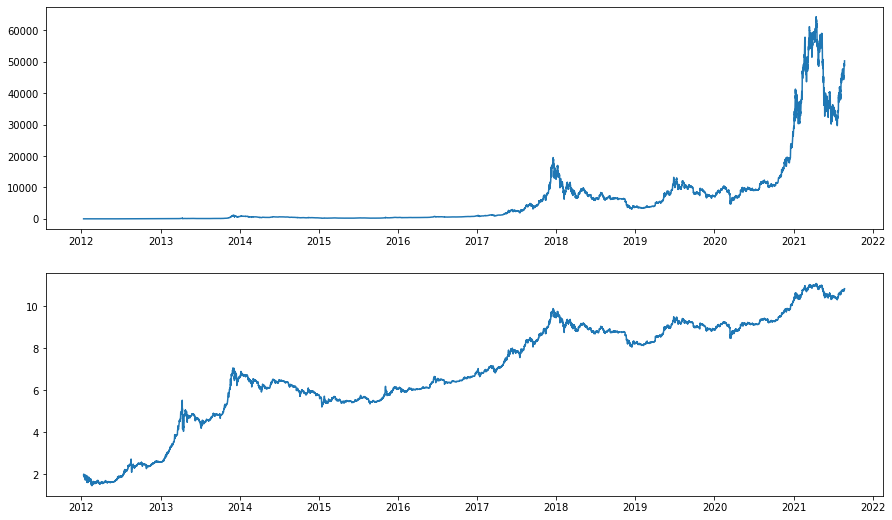

In [7]:
fig, axs = plt.subplots(2,1, figsize=(15,9))
axs[0].plot(data.close)
axs[1].plot(data.log_close)

In [8]:
data.keys()

Index(['open', 'high', 'low', 'close', 'volume', 'log_open', 'log_high',
       'log_low', 'log_close', 'ema12', 'dist_ema12', 'ema26', 'dist_ema26',
       'ema21', 'dist_ema21', 'ema50', 'dist_ema50', 'ema34', 'dist_ema34',
       'ema55', 'dist_ema55', 'ema99', 'dist_ema99', 'ema200', 'dist_ema200',
       'rsi', 'K', 'D', 'sma', 'bollinger_up', 'bollinger_down',
       'dist_bollinger_up', 'dist_bollinger_down', 'vol_roc', '4h Return',
       '4h Gradient', 'boll_width', 'stoch_rsi'],
      dtype='object')

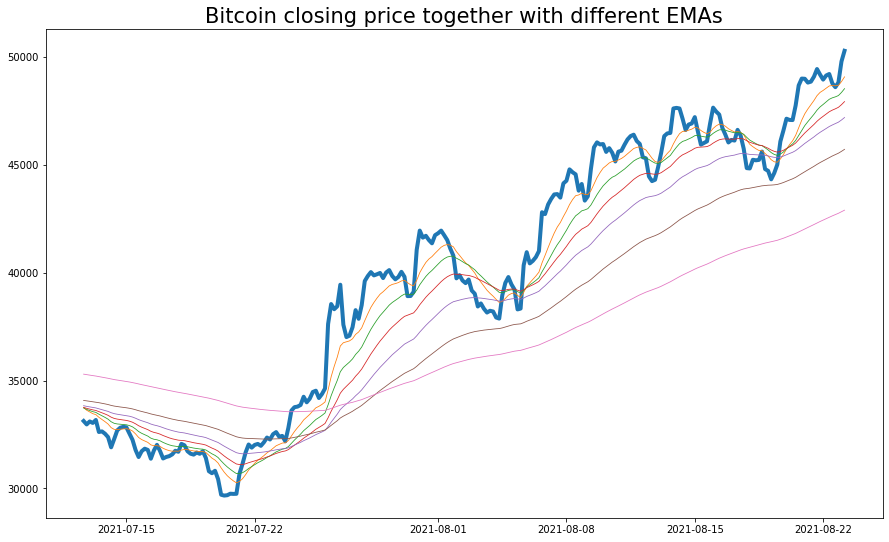

In [9]:
emas = [12, 21, 34, 55, 99, 200]
plt.figure(figsize=(15,9))
plt.plot(data.close[-250:],linewidth=4)
for i in emas:
    plt.plot(data[f'ema{i}'][-250:],linewidth=0.8)
plt.title('Bitcoin closing price together with different EMAs', fontsize=21)
plt.show()

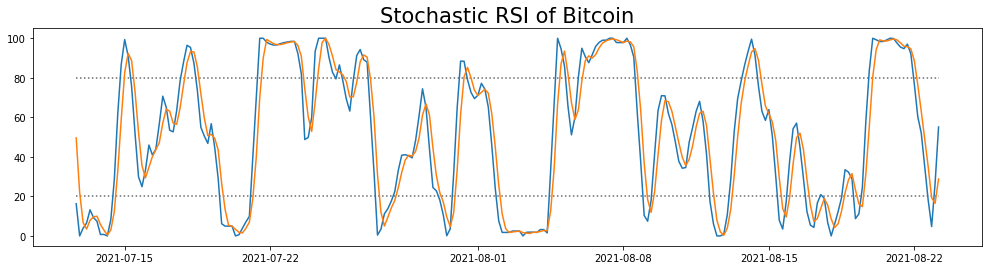

In [10]:
fig=plt.figure(figsize=(17,4))
plt.plot(data.K[-250:])
plt.plot(data.D[-250:])
plt.hlines(y=80, xmin=data.K[-250:].index[0], xmax=data.K[-250:].index[-1], color='dimgrey', linestyles='dotted')
plt.hlines(y=20, xmin=data.K[-250:].index[0], xmax=data.K[-250:].index[-1], color='dimgrey', linestyles='dotted')
plt.title("Stochastic RSI of Bitcoin", fontsize=21)
plt.show()

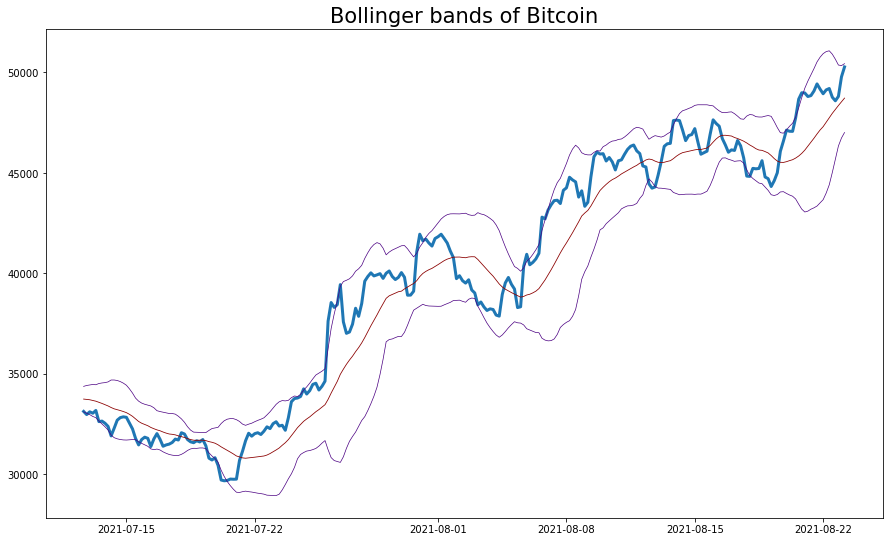

In [11]:
plt.figure(figsize=(15,9))
plt.plot(data.close[-250:],linewidth=3)
plt.plot(data.bollinger_up[-250:],color='indigo',linewidth=0.7)
plt.plot(data.bollinger_down[-250:],color='indigo',linewidth=0.7)
plt.plot(data.sma[-250:],color='darkred', linewidth=0.8)
plt.title("Bollinger bands of Bitcoin", fontsize=21)
plt.show()

In [12]:
selected_data = data[SELECTED_FEATURES]
selected_data.head()

,close
date,
2012-01-11 08:00:00,7.033333
2012-01-11 12:00:00,7.205769
2012-01-11 16:00:00,6.950000
2012-01-11 20:00:00,7.000000
2012-01-12 04:00:00,6.950000


In [13]:
coingecko = get_coingecko()

In [14]:
x_gecko = feature_engineer(coingecko)

In [15]:
x_gecko.dropna().shape

(149, 38)

# The Solution: LSTM

![lstm](https://cdn-images-1.medium.com/max/1600/1*O73nlRM3-bWubvt6W-1YSg.png)

In [16]:
# url = "https://api.coingecko.com/api/v3/coins/bitcoin/ohlc?vs_currency=usd&days=30"
# response = requests.get(url).json()

In [17]:
# data_api = pd.DataFrame(response, columns = ['unix_time','open', 'high', 'low', 'close'])
# data_api["Date"] = pd.to_datetime(data_api["unix_time"], unit='ms')
# data_api = data_api.drop(columns='unix_time').set_index('Date')

In [18]:
# data_api

# Welcome to Cryp2Moon!

[Your ticket to the moon](https://cryp2moon.herokuapp.com/)

# To Slides

In [19]:
!jupyter nbconvert projectweek_draft.ipynb --to slides --post serve \
--no-prompt \
--TagRemovePreprocessor.remove_input_tags=remove_input \
--TagRemovePreprocessor.remove_all_outputs_tags=remove_output

[NbConvertApp] WARNING | Config option `template_path` not recognized by `SlidesExporter`.  Did you mean one of: `extra_template_paths, template_name, template_paths`?
Traceback (most recent call last):
  File "/home/timjab92/.pyenv/versions/crypto/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/home/timjab92/.pyenv/versions/3.8.6/envs/crypto/lib/python3.8/site-packages/jupyter_core/application.py", line 254, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "/home/timjab92/.pyenv/versions/3.8.6/envs/crypto/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/home/timjab92/.pyenv/versions/3.8.6/envs/crypto/lib/python3.8/site-packages/nbconvert/nbconvertapp.py", line 346, in start
    self.convert_notebooks()
  File "/home/timjab92/.pyenv/versions/3.8.6/envs/crypto/lib/python3.8/site-packages/nbconvert/nbconvertapp.py", line 513, in convert_notebooks
  